In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from scipy import signal
from scipy.io import wavfile as wav
from scipy.fftpack import fft, fftfreq

import librosa

def wavToList(fileName):
    sampling_freq = 2000 # Hz
    data, rate = librosa.load(fileName, sr=sampling_freq) 
    return rate,data

def getTimeLength(rate,data):
    return(len(data)/rate)

def getSpectrogram(rate,data): #Gets timeBinFix time bins.. Note noverlap is 0. Not preferred, but we just went with it
    timeBinFix = 70
    nfft = 139
    nperseg = int(len(data)/timeBinFix)
    # print("number per segment: ", nperseg)
    frequencies, times, spectrogram = signal.spectrogram(data,rate,nfft=nfft,nperseg=nperseg, noverlap=0)
    return frequencies, times, spectrogram

2000 8000
70
Image shape:  (70, 70)


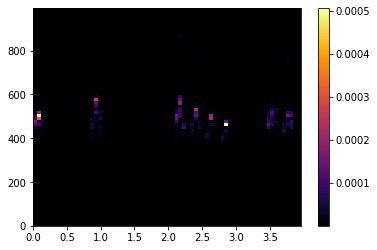

In [49]:
# Example Tuning
rate, data = wavToList(r'./urban-sounds/audio/fold1/7383-3-0-1.wav')
# rate, data = wavToList(r'./urban-sounds/audio/fold7/99812-1-2-0.wav')
print(rate, len(data))
frequencies, times, spectrogram = getSpectrogram(rate,data)
print(len(times))
print("Image shape: ", spectrogram.shape)
plt.imshow(spectrogram,extent=[0,np.max(times),0,np.max(frequencies)],cmap='inferno',aspect='auto',origin='lowest')
plt.colorbar()
# plt.savefig('pictures/dogbark.png', dpi=600)

In [50]:
# Full Dataset
urban = pd.read_csv(r'./urban-sounds/UrbanSound8K.csv')
urban

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [51]:
# # Reduced Dataset
# classesIDs = [1,2,3]
# dataset = []
# for classID in classesIDs:
#     dataset.append(urban[urban['classID'] == classID])
# urban_redux = pd.concat(dataset)
# urban_redux

In [53]:
design_matrix = []
files_list = []
times_list = []
count = 0
cropped_files = 0

t0 = time.time()

n_features = 70 #!!! Has to be the same as the number of timeBins in the spectrograms

for i in range(1,11):
    files = os.listdir(r'./urban-sounds/audio/fold'+str(i))[1:]
    for file in files:
        rate, data = wavToList(r'./urban-sounds/audio/fold'+str(i)+"/"+file)
        frequencies, times, spectrogram = getSpectrogram(rate,data)
        times_list.append(times)
        
        if spectrogram.shape[1] > n_features:
            spectrogram = spectrogram[:,:n_features]
            design_matrix.append(spectrogram)
            files_list.append(file)
            cropped_files +=1
        
        elif spectrogram.shape[1] < n_features:
            print("Interpolation Needed: ", file, spectrogram.shape, len(data))
            
        else:
            design_matrix.append(spectrogram)
            files_list.append(file)
        
        count += 1
        if count%500 == 0:
            print(count)
#         implement progress bar

run_time = time.time() - t0

# display run time
print('Spectrogram conversion run in %.3f s' % run_time)
print('Number of cropped files: ', cropped_files)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
Spectrogram conversion run in 1328.467 s
Number of cropped files:  559


In [58]:
# Check Dimensions
print(np.shape(design_matrix))
print(len(files_list))
print(len(times_list))

(8732, 70, 70)
8732
8732


In [55]:
# Add ClassID
class_list = []
for i in range(len(files_list)):
    class_list.append(int(urban[urban['slice_file_name']==files_list[i]]['classID']))
class_series = pd.Series(class_list)

In [45]:
# Build Dataframe ----> DataFrame not in Use
files_series = pd.Series(files_list)
spect_series = pd.Series(design_matrix)
df = pd.concat([files_series, spect_series,class_series], axis=1, sort=False)
df.columns = ['filename', 'spectrogram','classID']
df

,filename,spectrogram,classID
0,101415-3-0-2.wav,"[[2.8181438e-14, 1.7577188e-11, 2.8198418e-13,...",3
1,101415-3-0-3.wav,"[[1.1478878e-10, 7.763628e-12, 7.7532945e-11, ...",3
2,101415-3-0-8.wav,"[[4.7758877e-09, 1.1365628e-07, 1.2749109e-06,...",3
3,102106-3-0-0.wav,"[[2.1657601e-10, 7.507023e-09, 1.672574e-09, 4...",3
4,102305-6-0-0.wav,"[[2.8026157e-08, 3.6163385e-08, 1.5366695e-07,...",6
...,...,...,...
8727,99192-4-0-52.wav,"[[2.995166e-09, 3.924516e-09, 5.307684e-09, 3....",4
8728,99192-4-0-53.wav,"[[4.5114588e-09, 1.6387154e-06, 3.1965791e-07,...",4
8729,99192-4-0-54.wav,"[[3.559835e-08, 6.079095e-08, 1.8822174e-08, 6...",4
8730,99192-4-0-55.wav,"[[2.0314937e-08, 3.991396e-09, 2.416065e-08, 2...",4


In [57]:
# Make .npy file
# np.save("urban-processed/data.npy", design_matrix)
# np.save("urban-processed/files_list.npy", files_list)
# np.save("urban-processed/times_list.npy", times_list)
# np.save("urban-processed/class_list.npy", class_list)
np.save("urban-processed/data70.npy", design_matrix)
np.save("urban-processed/files_list70.npy", files_list)
np.save("urban-processed/times_list70.npy", times_list)
np.save("urban-processed/class_list70.npy", class_list)

In [ ]:
print(np.shape())

## Start With Saved Data ##

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
### START (Avoid Previous Process) ###
design_matrix = np.load("urban-processed/data.npy")
files_list = np.load("urban-processed/files_list.npy")
times_list = np.load("urban-processed/times_list.npy")
class_list = np.load("urban-processed/class_list.npy")

## Principal Component Analysis (PCA) ##

In [17]:
# flattem spectrograms
flat_spectrograms = []
for i in range(len(design_matrix)):
    flat_spectrograms.append(design_matrix[i].flatten())
print(np.shape(flat_spectrograms))

(8732, 90000)


In [19]:
from sklearn.decomposition import PCA
import time

t0 = time.time()

pca = PCA()
pca.fit(flat_spectrograms)

run_time = time.time() - t0

# display run time
print('Full PCA run in %.3f s' % run_time)

Full PCA run in 1008.265 s


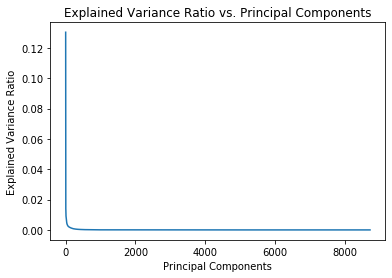

In [202]:
# plot explained variance ratio
plt.title('Explained Variance Ratio vs. Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
plt.savefig('pictures/ExplainedVar.png', dpi=600)
plt.show()

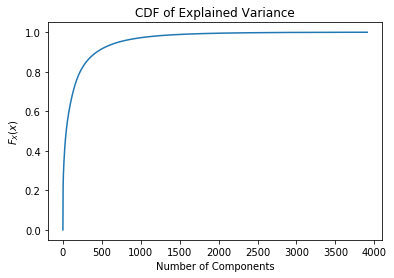

Optimal Dimensions:  3128


In [203]:
### CDF of PCA ###

cdf = [0]
default_reduced_dim = 0.5*len(flat_spectrograms[0])
reduced_dim = default_reduced_dim

# calculate CDF
for n_components in range(1,len(flat_spectrograms[0])+1):
    F = np.linalg.norm(pca.explained_variance_ratio_[:n_components], ord=1)
    # pick number of principal components that express at least 99% of the data
    if 0.99 < F <= 0.999:
        reduced_dim = n_components
    cdf.append(F)

# plot CDF vs. number components
plt.title('CDF of Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('$F_{X}(x)$')
# plt.plot(range(0,len(cdf)),cdf)
xlim = int(1.25*reduced_dim)
plt.plot(range(0, xlim), cdf[:xlim])
plt.savefig('pictures/CDF.png', dpi=600)
plt.show()

print("Optimal Dimensions: ", reduced_dim)

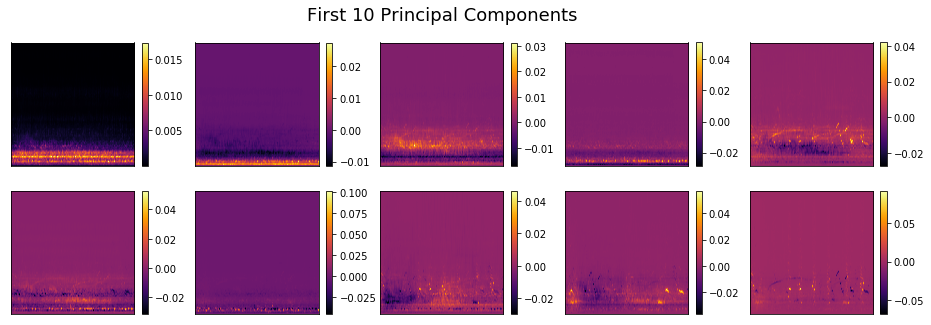

In [201]:
### First 10 Frincipal Components ###
plt.figure(figsize=(16, 5))
for i in range(10):
    pc_plot = plt.subplot(2, 5, i + 1)
    im = pc_plot.imshow(pca.components_[i].reshape(300,300), cmap='inferno', origin='lowest')
    pc_plot.imshow(pca.components_[i].reshape(300,300), cmap='inferno',aspect='auto', origin='lowest')
    fig.colorbar(im,ax=pc_plot)
#     pc_plot.set_xticks(())
#     pc_plot.set_yticks(())
plt.suptitle('First 10 Principal Components', fontsize=18)
plt.savefig('pictures/First10PC.png', dpi=1200)
plt.show()

In [53]:
### Transformed Matrix ###

X_pca = pca.transform(flat_spectrograms)

In [195]:
### PCA Reduced Spectrogram ###
t0 = time.time()

reduced_spectro = PCA(n_components=reduced_dim).fit_transform(flat_spectrograms)

run_time = time.time() - t0

# display run time
print('Reduced  run in %.3f s' % run_time)

Reduced  run in 608.404 s


In [316]:
### GRAPHING PCA ###
def graphComp(class_list, cdict, labl, Xax, Yax, comp_x, comp_y):
    fig,ax=plt.subplots(figsize=(7,5))
    fig.patch.set_facecolor('white')

    for l in np.unique(class_list):
        ix=np.where(class_list==l)
        ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=20, label=labl[l],marker='o', alpha=0.7)
    
    plt.xlim(-0.025,0.06)
    plt.xlabel("PCA-"+str(comp_x))
    plt.ylabel("PCA-"+str(comp_y))
    plt.legend()
    plt.savefig('pictures/PCA'+str(comp_x)+'vsPCA'+str(comp_y)+'.png', dpi=600)
    plt.show()

In [363]:
### GRAPHING COMPONENTS SEPARATELY ###
def graphCompSeparately(class_list, cdict, labl, Xax, Yax, comp_x, comp_y):
    fig,ax=plt.subplots(figsize=(16,5))
    fig.patch.set_facecolor('white')
    fig.tight_layout()
    
    for l in np.unique(class_list):
        ix=np.where(class_list==l)
        pc_plot = plt.subplot(2, 5, l + 1)
        pc_plot.scatter(Xax[ix],Yax[ix],c=cdict[l],s=20, label=labl[l],marker='o', alpha=0.7)
        pc_plot.legend()
        
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
    plt.xlim(-0.025,0.06)
    fig.suptitle("PCA-"+str(comp_x)+" vs. PCA-"+str(comp_y), fontsize=18, y=1.09)
    plt.savefig('pictures/PCA'+str(comp_x)+'vsPCA'+str(comp_y)+'_ByClass.png', dpi=600)
    plt.show()

In [364]:
### Graphs Class Parameters ###

# cdict={0:'red',1:'green',2:'blue', 3:'orange', 4:'brown', 5:'purple',
#        6:'pink', 7:'olive', 8:'gray', 9:'cyan', 10:'cyan'}
cdict={0:'#1f77b4', 1:'#ff7f0e', 2:'#2ca02c', 3:'#d62728', 4:'#9467bd', 5:'#8c564b',
       6:'#e377c2', 7:'#7f7f7f', 8:'#bcbd22', 9:'#17becf'}

labl={0:'air conditioner',1:'car horn',2:'children', 3:'dog bark', 4:'drilling', 5:'engine',
      6:'gun shot', 7:'jackhammer', 8:'siren', 9:'street music'}

# marker={0:'*',1:'o'}

# alpha={0:.3, 1:.5}

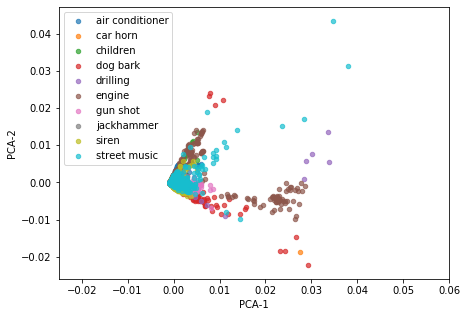

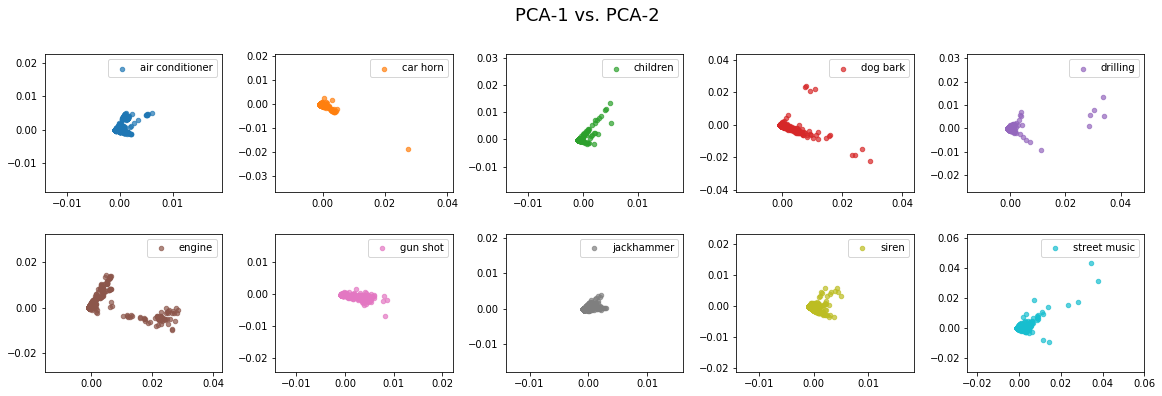

In [365]:
# First and Second Component
comp_x = 1
comp_y = 2
Xax=X_pca[:,comp_x-1]
Yax=X_pca[:,comp_y-1]
graphComp(class_list, cdict, labl, Xax, Yax, comp_x, comp_y)
graphCompSeparately(class_list, cdict, labl, Xax, Yax, comp_x, comp_y)

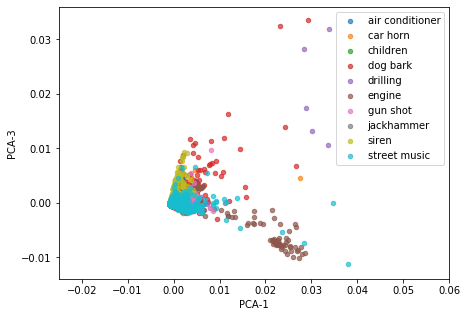

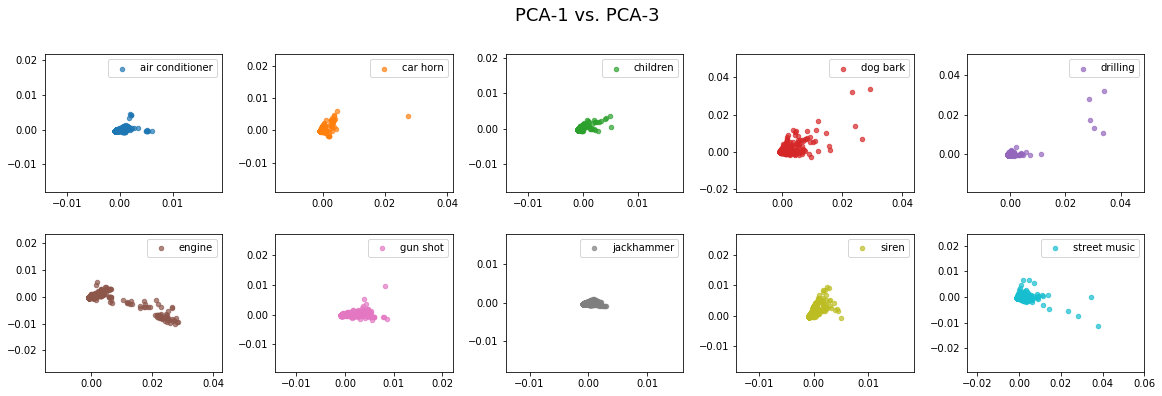

In [368]:
# First and Third Component
comp_x = 1
comp_y = 3
Xax=X_pca[:,comp_x-1]
Yax=X_pca[:,comp_y-1]
graphComp(class_list, cdict, labl, Xax, Yax, comp_x, comp_y)
graphCompSeparately(class_list, cdict, labl, Xax, Yax, comp_x, comp_y)

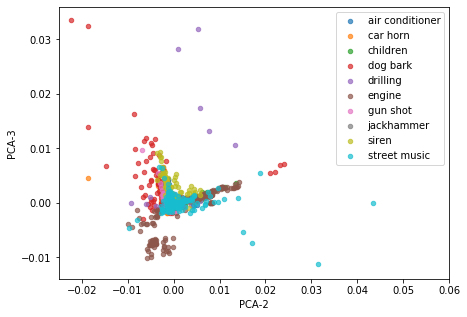

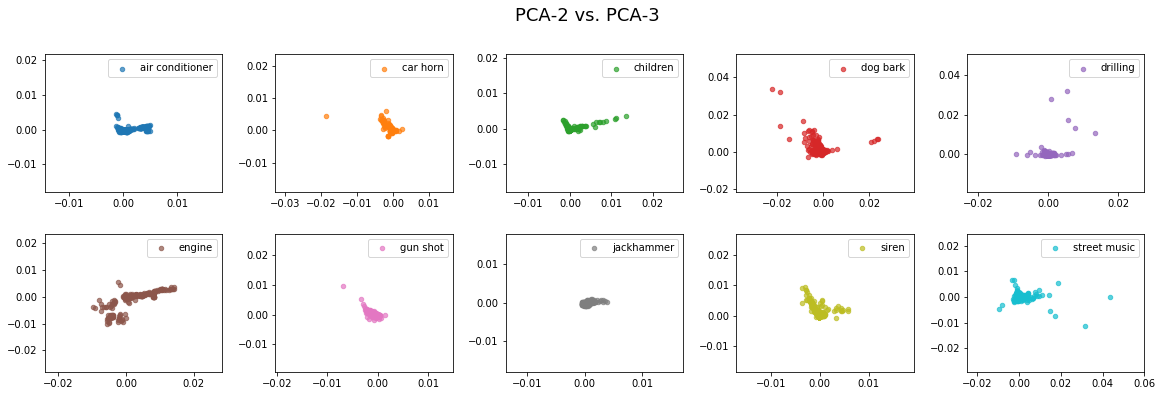

In [369]:
# Second and Third Component
comp_x = 2
comp_y = 3
Xax=X_pca[:,comp_x-1]
Yax=X_pca[:,comp_y-1]
graphComp(class_list, cdict, labl, Xax, Yax, comp_x, comp_y)
graphCompSeparately(class_list, cdict, labl, Xax, Yax, comp_x, comp_y)

c:\users\faizg\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


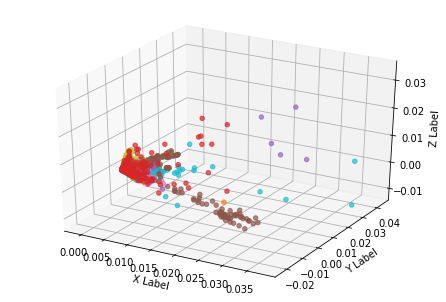

In [280]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

fig = p.figure()
# ax = fig.add_subplot(111, projection='3d')
ax = p3.Axes3D(fig)

x =X_pca[:,0]
y =X_pca[:,1]
z =X_pca[:,2]

for l in np.unique(class_list):
        ix=np.where(class_list==l)
        ax.scatter(x[ix],y[ix],z[ix],c=cdict[l],s=20, label=labl[l],marker='o', alpha=0.7)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# plt.show()

fig.add_axes(ax)
p.show()

In [206]:
## FIX!!! CRASHES

from sklearn.manifold import TSNE

# Perform t-distributed stochastic neighbor embedding.
tsne = TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(reduced_spectro)

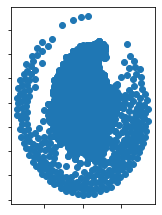

In [231]:
from matplotlib.ticker import NullFormatter
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(trans_data[:,0], trans_data[:,1], cmap=plt.cm.rainbow)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

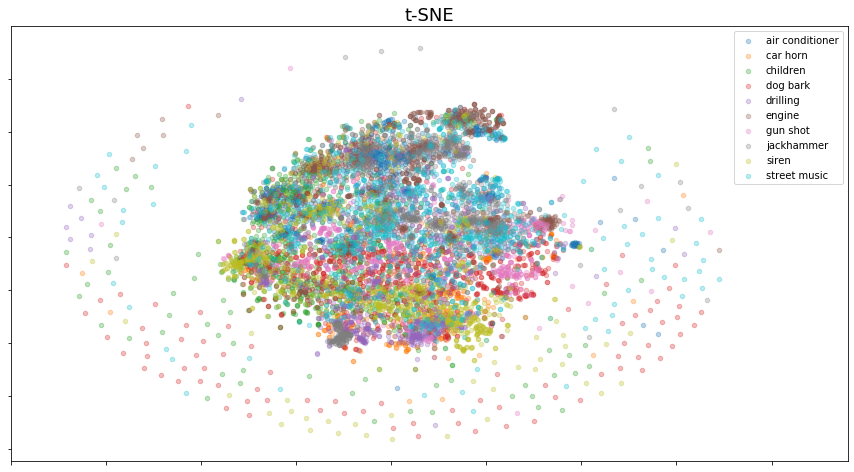

In [375]:
X_tsne = trans_data[:,0]
Y_tsne = trans_data[:,1]

from matplotlib.ticker import NullFormatter
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)

for l in np.unique(class_list):
        ix=np.where(class_list==l)
        ax.scatter(X_tsne[ix],Y_tsne[ix],c=cdict[l],s=20, label=labl[l],marker='o', alpha=0.3)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
        
plt.legend()
plt.xlim(-100,120)
plt.title('t-SNE', fontsize=18)
plt.savefig('t-SNE2.png', dpi=600)
plt.show()

In [218]:
### FULL T-SNE ###

# full_tsne = TSNE(n_components=2, init='pca', random_state=0)
# full_trans_data = full_tsne.fit_transform(flat_spectrograms)

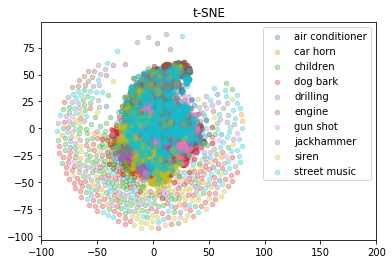

In [380]:
X_tsne_full = full_trans_data[:,0]
Y_tsne_full = full_trans_data[:,1]

from matplotlib.ticker import NullFormatter
# fig = plt.figure(figsize=(15, 8))
# ax = fig.add_subplot(2, 5, 10)

for l in np.unique(class_list):
        ix=np.where(class_list==l)
        plt.scatter(X_tsne_full[ix],Y_tsne_full[ix],c=cdict[l],s=20, label=labl[l],marker='o', alpha=0.3)
#         plt.axis.set_major_formatter(NullFormatter())
#         plt.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
        
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlim(-100,200)
plt.title('t-SNE')
plt.savefig('t-SNE.png', dpi=600)
plt.show()

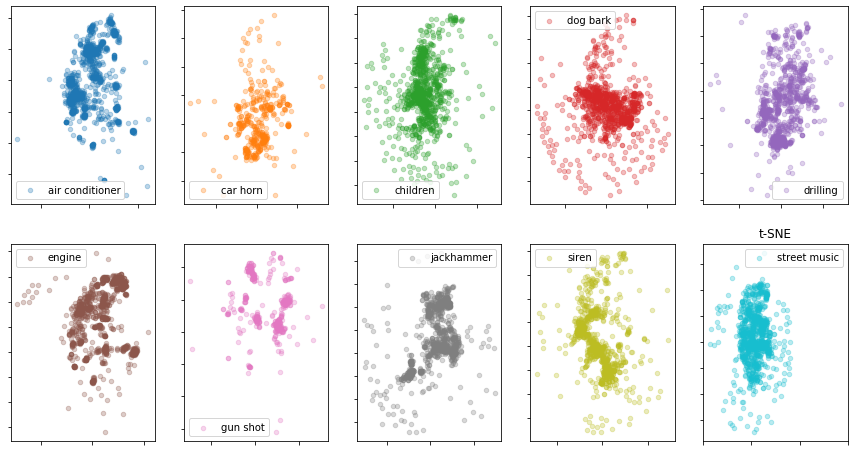

In [379]:
fig = plt.figure(figsize=(15, 8))

for l in np.unique(class_list):
        ix=np.where(class_list==l)
        ax = fig.add_subplot(2, 5, l+1)
        ax.scatter(X_tsne_full[ix],Y_tsne_full[ix],c=cdict[l],s=20, label=labl[l],marker='o', alpha=0.3)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
        plt.legend()
        
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-100,200)
plt.title('t-SNE')
plt.savefig('t-SNE_ByClasses.png', dpi=600)
plt.show()